<a href="https://colab.research.google.com/github/naku2001/TextClassification/blob/main/Active_Learning_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import ops
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

In [2]:
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Total examples: 50000


In [3]:
val_split = 2500
test_split = 2500
train_split = 7500

In [4]:
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]



Creating training, validation and testing splits

In [6]:
x_val, y_value =(
    tf.concat((x_positives[:val_split], x_negatives[:val_split]),0),
    tf.concat((y_positives[:val_split],y_negatives[:val_split]),0)
)

In [8]:
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)

In [9]:
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)


Remaining pool of samples are stored separately

In [10]:
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

Creating TF Datasets for faster prefetching and parallelization

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_value))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [14]:
pool_positives = tf.data.Dataset.from_tensor_slices((x_pool_positives,y_pool_negatives))
pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)

In [15]:
print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


Fitting the TextVectorization layer

In [18]:
vectorizer = layers.TextVectorization(
    3000, standardize="lower_and_strip_punctuation", output_sequence_length=150
)

In [20]:
vectorizer.adapt(train_dataset.map(lambda x,y:x,num_parallel_calls=tf.data.AUTOTUNE).batch(256))

In [21]:
def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label

In [22]:
train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

In [23]:
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

In [25]:
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy

In [26]:
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

 bidirectional LSTM model

In [36]:
def create_model():
  model = keras.models.Sequential([layers.Input(shape=(150,)),
                                   layers.Embedding(input_dim=3000,output_dim=128),
                                   layers.Bidirectional(layers.LSTM(32,return_sequences=True)),
                                   layers.GlobalMaxPool1D(),
                                   layers.Dense(20,activation="relu"),
                                   layers.Dropout(0.5),
                                   layers.Dense(1,activation ="sigmoid")])
  model.summary()
  return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.7460 - false_negatives: 4454.7178 - false_positives: 41.7949 - loss: 0.5680
Epoch 1: val_loss improved from inf to 1.02014, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - binary_accuracy: 0.7468 - false_negatives: 4492.9492 - false_positives: 41.7975 - loss: 0.5670 - val_binary_accuracy: 0.5000 - val_false_negatives: 2500.0000 - val_false_positives: 0.0000e+00 - val_loss: 1.0201
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.7494 - false_negatives: 4449.9492 - false_positives: 3.8025 - loss: 0.5665
Epoch 2: val_loss improved from 1.02014 to 0.93662, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.7498 - false_negatives: 4469.2471 - false_positives: 3.8038 - loss: 0.5660 - val_binary_accuracy: 0.5000 - val_false_negatives: 2500.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.9366
Epoch 3

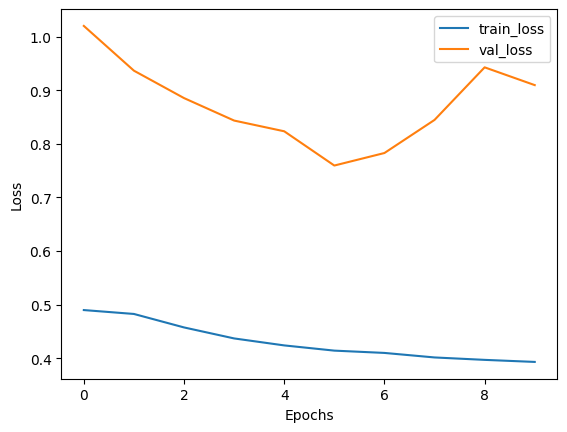

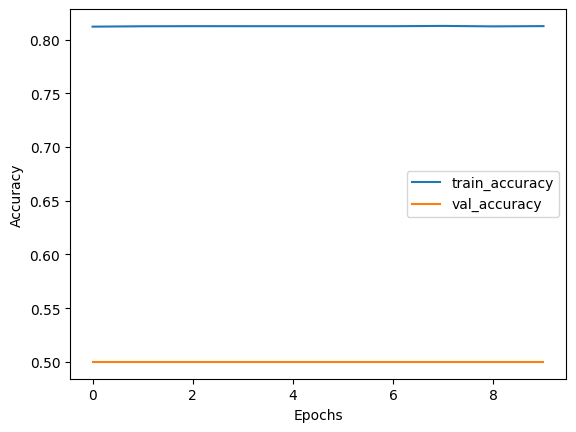

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.5, 'false_negatives': 2500.0, 'false_positives': 0.0, 'loss': 0.7724657654762268}
----------------------------------------------------------------------------------------------------


In [37]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.keras", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.keras")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

Implementing Active Learning

In [ ]:
def train_active_learning_models(train_dataset,pool_negatives,pool_positives,val_datasets,test_dataset,num_iterations =3,sampling_size=5000,):
  losses, val_losses, accuracies, val_accuracies = [],[],[],[]
  model = create_model()
  model.compile(loss = "binary_crossentropy",optimizer="rmsprop",metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.FalseNegatives(),keras.metrics.FalsePositives(),],)
  checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.keras", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
  early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)
  history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )
  losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )
